In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from typing import List, Tuple, Union, Callable, Dict, Iterator
from collections import defaultdict
from difflib import SequenceMatcher
import spacy 
from spacy.matcher import Matcher, PhraseMatcher
from spacy.tokens.doc import Doc
from spacy.tokens.span import Span
from spacy.tokens.token import Token
from geotext import GeoText ## new library: https://pypi.org/project/geotext/

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
filenames = os.listdir(r'C:\Users\12482\Desktop\lambda-school\labs\project\textfolder\text_cases') # Wherever files are located

In [4]:
def similar(a: str, return_b: str, min_score: float) -> Union[str, None]:
    """
    • Returns 2nd string if similarity score is above supplied
    minimum score. Else, returns None.
    """
    if SequenceMatcher(None, a, return_b).ratio() >= min_score:
        return return_b


def similar_in_list(lst: Union[List[str], Iterator[str]]) -> Callable:
    """
    • Uses a closure on supplied list to return a function that iterates over
    the list in order to search for the first similar term. It's used widely
    in the scraper.
    """

    def impl(item: str, min_score: float) -> Union[str, None]:
        for s in lst:
            s = similar(item, s, min_score)
            if s:
                return s

    return impl

In [5]:
members = [
    "Adkins-Blanch, Charles K.",
    "Michael P. Baird",
    "Cassidy, William A.",
    "Cole, Patricia A.",
    "Couch, V. Stuart",
    "Creppy, Michael J.",
    "Crossett, John P.",
    "Donovan, Teresa L.",
    "Foote, Megan E.",
    "Geller, Joan B.",
    "Gemoets, Marcos",
    "Gonzalez, Gabriel",
    "Goodwin, Deborah K.",
    "Gorman, Stephanie E.",
    "Grant, Edward R.",
    "Greer, Anne J.",
    "Guendelsberger, John",
    "Hunsucker, Keith E.",
    "Kelly, Edward F.",
    "Kendall Clark, Molly",
    "Liebmann, Beth S.",
    "Liebowitz, Ellen C.",
    "Mahtabfar, Sunita B.",
    "Malphrus, Garry D.",
    "Mann, Ana",
    "Miller, Neil P.",
    "Monsky, Megan Foote",
    "Montante Jr., Phillip J.",
    "Morris, Daniel",
    "Mullane, Hugh G.",
    "Neal, David L.",
    "Noferi, Mark",
    "O'Connor, Blair",
    "O'Herron, Margaret M.",
    "O'Leary, Brian M.",
    "Owen, Sirce E.",
    "Pauley, Roger",
    "Petty, Aaron R.",
    "Pepper, S. Kathleen",
    "RILEY, KEVIN W.",
    "Rosen, Scott",
    "Snow, Thomas G.",
    "Swanwick, Daniel L.",
    "Wendtland, Linda S.",
    "Wetmore, David H.",
    "Wilson, Earle B."
]

In [6]:
judges_url = 'https://en.wikipedia.org/wiki/Board_of_Immigration_Appeals'
html = requests.get(judges_url).text
soup = BeautifulSoup(html, 'html.parser')
table = soup.find("table", class_="wikitable")
web_judges = [itm.get_text().strip() for itm in table.select("td")[1::4]]

web_judges

['David H. Wetmore',
 'Charles Adkins-Blanch',
 'Garry D. Malphrus',
 'Michael P. Baird',
 'William A. Cassidy',
 'V. Stuart Couch',
 'Michael J. Creppy',
 'Deborah K. Goodwin',
 'Stephanie E. Gorman',
 'Edward R. Grant',
 'Anne J. Greer',
 'Keith E. Hunsucker',
 'Edward F. Kelly',
 'Ellen Liebowitz',
 'Sunita B. Mahtabfar',
 'Ana Landazabal Mann',
 'Philip J. Montante, Jr.',
 'Hugh Mullane',
 "Blair O'Connor",
 'Sirce E. Owen',
 'Aaron R. Petty',
 'Kevin W. Riley',
 'Earle B. Wilson',
 'Megan Foote Monsky',
 'Joan B. Geller',
 'Gabriel Gonzalez',
 'Beth Liebmann',
 'Mark Noferi',
 'S. Kathleen Pepper']

In [7]:
combined_members = members + web_judges

In [8]:
class GetJudge:
    """ Returns the judge's name if a match is found. """
    accuracy = 0.7

    def __init__(self):
        # Currently grabs potential judges names from a URL here.
        # For testing we'll instead alternate `names`

#         names = web_judges
#         names = members
        names = combined_members
        self.is_judge: Callable = similar_in_list(names)

    def __call__(self, name):
        result = self.is_judge(name, self.accuracy)
        if not result:
            flip_name = ' '.join(reversed(name.split(', ')))
            result = self.is_judge(flip_name, self.accuracy)
        return result


class BIACase:
    def __init__(self, text: str):
        """
        Input will be text from a BIA case pdf file, after the pdf has
        been converted from PDF to text.
        Scraping works utilizing spaCy, tokenizing the text, and iterating
        token by token searching for matching keywords.
        """
        self.doc: Doc = nlp(text)
        self.ents: Tuple[Span] = self.doc.ents
        self.if_judge = GetJudge()

    def get_ents(self, labels: List[str]) -> Iterator[Span]:
        """
        Retrieves entities of a specified label(s) in the document,
        if no label is specified, returns all entities
        """
        return (ent for ent in self.ents if ent.label_ in labels)

    def get_panel(self) -> str:
        """
        Returns the panel members of case in document.
        """
        panel_members: List[str]
        panel_members = []
        possible_members: Iterator[Span]
        possible_members = map(
            lambda ent: ent.text, self.get_ents(['PERSON'])
        )
        for member in possible_members:
            judge: Union[str, None]
            judge = self.if_judge(member)
            if judge:
                panel_members.append(judge)

        return '; '.join(set(panel_members))

In [9]:
# ** Change `names` to `web_judges` list in GetJudge() **
web_dict = {}

for file in filenames:
    f = open(f"C:\\Users\\12482\\Desktop\\lambda-school\\labs\\project\\textfolder\\text_cases\\{file}", "r",encoding='utf-8')
    case = BIACase(f.read())
    web_dict[file] = case.get_panel()
    f.close()

### NEW WORK BELOW

In [49]:
## idea: create a dataframe with a multitude of features 

## feature 1 is num of panel members -- > do first

## feature 2 is most significant place --> do next

## ....... 

## create df

In [54]:
l = list(web_dict.keys()) ## easy access to dict
len(web_dict[l[0]].split(',')) ## example --> value is number of panel members

2

In [56]:
def func(dict_):
    
    panel = []
    
    l = list(dict_.keys())
    
    for x in l:
        panel.append(len(dict_[x].split(',')))
        
    return panel

panel_len = func(web_dict)

In [26]:
cache = {}

for i in range(len(filenames)):
    cache[i] = open(f"C:\\Users\\12482\\Desktop\\lambda-school\\labs\\project\\textfolder\\text_cases\\{filenames[i]}", "r",encoding='utf-8')
    cache[i] = cache[i].read()

In [47]:
from collections import Counter # --> returns dict (k:v, for k=word,v=count in file)

def func(data):
    
    file_count = []
    
    for i in range(len(data)):
        file = data[i]
        cities_in_file = GeoText(file).cities
        c = Counter(cities_in_file)
        file_count.append(c.most_common(1))
        
    return file_count

city_count = func(data=cache)

In [68]:
def func(data):
    l = []
    for i in range(len(data)):
        l.append(data[i][0][0])
    return l
cities = func(city_count)

In [69]:
df = pd.DataFrame()
df['city'] = cities
df['panel_count'] = panel_len
df.head()

,city,panel_count
0,Los Angeles,2
1,Virginia,1
2,Virginia,1
3,New York,1
4,March,1


In [74]:
import category_encoders as ce

enc = ce.OrdinalEncoder()
enc.fit(df['city'])
new = enc.transform(df['city'])

In [76]:
df['city'] = new
df.head()

,city,panel_count
0,1,2
1,2,1
2,2,1
3,3,1
4,4,1


<AxesSubplot:>

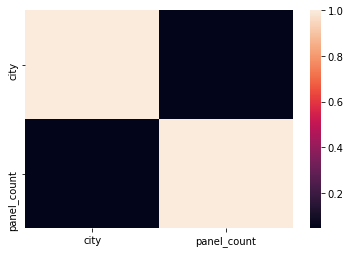

In [80]:
import seaborn as sns
sns.heatmap(df.corr())

### NEED TO ENGINEER MORE FEATURES !